# Understanding the Dataset and Question

> Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

## Introduction

The Enron fraud is the largest case of corporate fraud in American history. Founded in 1985, Enron Corporation went bankrupt by end of 2001 due to widespread corporate fraud and corruption. Before its fall, Fortune magzine had named Enron "America's most innovative company" for six consecutive years. So what happened? Who were the culprits?

In this project, I will play detective and build a classification algorithm to predict a person of interest identifier (POI) based on email and financial features in the combined dataset. A POI is anyone who has been indicted, settled without admitting the guilt and testified in exchange for immunity. We will check our predicted POI against actual POI in the dataset to evaluate our prediction.

In [1]:
import numpy as np
import pandas as pd

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester_plus import dump_classifier_and_data

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
enron_data = pd.DataFrame.from_dict(data_dict, orient = 'index')

## Data Exploration

Lets print few lines from the dataset.

In [4]:
enron_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [5]:
print "There are a total of {} people in the dataset." .format(len(enron_data.index)) 
print "Out of which {} are POI and {} Non-POI." .format(enron_data['poi'].value_counts()[True], 
                                                 enron_data['poi'].value_counts()[False])
print "Total number of email plus financial features are {}. 'poi' column is our label." \
.format(len(enron_data.columns)-1)

There are a total of 146 people in the dataset.
Out of which 18 are POI and 128 Non-POI.
Total number of email plus financial features are 20. 'poi' column is our label.


Enron dataset is really messy and has a lot of missing values(NaN). All the features have missing values. Some features have more than 50% of their values missing, as we can see from the frequency of NaN from the table below. NaNs are coerced to 0 for training our algorithm later.

In [6]:
enron_data.describe().transpose()

,count,unique,top,freq
salary,146,95,NaN,51
to_messages,146,87,NaN,60
deferral_payments,146,40,NaN,107
total_payments,146,126,NaN,21
exercised_stock_options,146,102,NaN,44
bonus,146,42,NaN,64
restricted_stock,146,98,NaN,36
shared_receipt_with_poi,146,84,NaN,60
restricted_stock_deferred,146,19,NaN,128
total_stock_value,146,125,NaN,20


In [7]:
enron_data.replace(to_replace='NaN', value=0.0, inplace=True)

## Outlier investigation

Visualization is one of the most powerful tool for finding outliers. Upon plotting salary against bonus, there is an outlier that pops out immediately - "TOTAL" (move the cursor and examine the points in scatterplot). The spreadsheet added up all the data points for us and we need to take that point out. Upon closer examination, I found one more entry which is not the name of real person "THE TRAVEL AGENCY IN THE PARK". The entry is dropped from the dataset. The entries which has all the features as 'NaN' are also dropped from the dataset.

In [8]:
# Import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

# Make scatterplot before outlier removal
trace0 = go.Scatter(
    x=enron_data.salary,
    y=enron_data.bonus,
    text = enron_data.index,
    mode = 'markers'
)

# Remove Outlier
enron_data.drop(['TOTAL'], axis = 0, inplace= True)

# Make scatterplot after outlier removal
trace1 = go.Scatter(
    x=enron_data.salary,
    y=enron_data.bonus,
    text = enron_data.index,
    mode = 'markers'
)

# Layout the plots together side by side
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Before outlier removal', 'After outlier removal'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout']['xaxis1'].update(title='salary')
fig['layout']['xaxis2'].update(title='salary')

fig['layout']['yaxis1'].update(title='bonus')
fig['layout']['yaxis2'].update(title='bonus')

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [9]:
enron_data.drop(['THE TRAVEL AGENCY IN THE PARK'], axis = 0, inplace= True)

# Optimize Feature Selection/Engineering

> What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.

## Feature engineering

Feature engineering involves using human intuition to hypothesize what feature might contain pattern that can be exploited using machine learning, coding up the new feature, visualizing and repeating the same process again. Our hypothesis here - "POI's sent email to each other at a rate higher than for Non-POI's." I coded up two new features fraction of emails this person gets from poi (fraction_from_poi) and fraction of emails this person send to poi (fraction_to_poi).
number of emails from this person to POI/total number of message from this person

$$fraction\_from\_poi =\frac{number\ of\ emails\ from\ POI\ to\ this\ person}{total\ number\ of\ message\ to\ this\ person} = \frac{from\_poi\_to\_this\_person}{to\_messages}$$

$$fraction\_to\_poi = \frac{number\ of\ emails\ from\ this\ person\ to\ POI}{total\ number\ of\ message\ from\ this\ person} = \frac{from\_this\_person\_to\_poi}{from\_messages}$$

When I visualize these new features, we can see that these new features provide discriminating power between POI and Non-POI. There is a good amount of feature space in the lower part of plot (on right) below 0.2 where there are no POIs.

In [10]:
#Create new feature(s)
enron_data["fraction_from_poi"] = enron_data["from_poi_to_this_person"].\
divide(enron_data["to_messages"], fill_value = 0)

enron_data["fraction_to_poi"] = enron_data["from_this_person_to_poi"].\
divide(enron_data["from_messages"], fill_value = 0)

In [11]:
enron_data["fraction_from_poi"] = enron_data["fraction_from_poi"].fillna(0.0)
enron_data["fraction_to_poi"] = enron_data["fraction_to_poi"].fillna(0.0)

In [12]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.models import ColumnDataSource

output_notebook()

colormap = {False: 'blue', True: 'red'}
colors = [colormap[x] for x in enron_data['poi']]

labelmap = {False: 'Non-POI', True: 'POI'}
labels = [labelmap[x] for x in enron_data['poi']]

source = ColumnDataSource(dict(
    x1=enron_data["from_poi_to_this_person"],
    y1=enron_data["from_this_person_to_poi"],
    x2=enron_data["fraction_from_poi"],
    y2=enron_data["fraction_to_poi"],
    color=colors,
    label=labels
))

# Before feature engineering
s1 = figure(plot_width=450, plot_height=400)
s1.xaxis.axis_label = 'no. of emails from POI to this person'
s1.yaxis.axis_label = 'no. of emails from this person to POI'

s1.circle('x1', 'y1', size = 10, alpha = 0.5, 
          color='color', legend = 'label', source = source)

# After feature engineering
s2 = figure(plot_width=450, plot_height=400)
s2.xaxis.axis_label = 'fraction of emails this person gets from POI'
s2.yaxis.axis_label = 'fraction of emails this person sends to POI'

s2.circle('x2', 'y2', size = 10, alpha = 0.5, 
          color='color', legend = 'label', source = source)

show(row(s1, s2))

Loading BokehJS ...

## Feature Scaling

I have used **decision tree** as my final algorithm. Algorithms like decision tree and linear regression don't require feature scaling, whereas Support Vector Machines (SVM) and k-means clustering does.

**SVM** and **k-means** clustering calculate Euclidean distance between points. If one of the features has a large range, the distance will be governed by this particular feature. These classifiers are **affine transformation variant**.

In case of **linear regression**, there is a coefficient with each feature. If a feature has large ranges that do not effect the label, regression algorithm will make the corresponding coefficients small. Even in case of **tree based algorithms**, we don't have to worry about one dimension, when we are doing something with the other. These classifers are **affine transformation invariant**.

## Feature Selection

In [13]:
# Store to my_dataset for easy export below.
# create a dictionary from the dataframe
my_dataset = enron_data.to_dict('index')

Features $\neq$ Information. We want to have the minimum number of features than capture trends and patterns in our data. We want to get rid of features that don't give us any information. Machine learning algorithm is just going to be as good as the features we put into it. It is critical that the methodology deployed for feature selection must be scientific and exhaustive without room for intuition.

First I manually removed features which had more than 50% of the values missing (NaN), then I performed [SelectKBest](http://scikit-learn.org/stable/modules/feature_selection.html) on remaining features and selected eight features with scores greater than 2. 

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

features_list = ["poi", "bonus", "exercised_stock_options", "expenses", "other", "restricted_stock", "salary", 
                  "shared_receipt_with_poi", "total_payments", "total_stock_value", "fraction_to_poi",
                 "fraction_from_poi"]

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(features, labels)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Bokeh Barplots
from bokeh.charts import Bar, show

data = {'scores':scores, 'features':features_list[1:]}
bar = Bar(data, label='features', values='scores', title="Select K Best", 
          legend = None, plot_width = 450, plot_height = 450)

show(bar)

Finally, I used ['feature_importances'](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) attribute of my Decision Tree classifier to select  four features (bonus, exercised_stock_options, fraction_to_poi and shared_receipt_with_poi) that maximized my F1 score. Implementing my final algorithm without the newly engineered feature fraction_to_poi, dropped my F1-score by 74% (from 0.47547 to 0.12157). This also shows the effect of this feature on the final algorithm performance.

In [15]:
features_list = ["poi", "bonus", "exercised_stock_options", 
                 "fraction_to_poi", "shared_receipt_with_poi"]
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [16]:
# These are feature importance I obtained from running my final classiifer and testing it with tester.py.
# Check Algorithm Performance section below.
feature_importances = [0.13442256, 0.0433088, 0.48651064, 0.335758]
from bokeh.charts import Bar, show

data = {'importance':feature_importances, 'features':features_list[1:]}
bar = Bar(data, label='features', values='importance', title="Feature importances from fitted Decision Tree", 
          legend = None, plot_width = 400, plot_height = 400)

show(bar)

# Pick and Tune an Algorithm

> What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?

## Pick an algorithm

Different algorithms were attempted using the four best features:- bonus, exercised_stock_options, fraction_to_poi and shared_receipt_with_poi.

In [17]:
# Not restricting the maximum width in characters of a column
pd.options.display.max_colwidth = 0
data = {"Algorithms":["DecisionTreeClassifier", 
                      "RandomForestClassifier",
                      "AdaBoostClassifier",
                      "GaussianNB"],
        "Parameters":["criterion='entropy', max_depth =2, min_samples_split=2, min_samples_leaf=6", 
                      "n_estimators=150, min_samples_split=5", 
                      "n_estimators=150",
                      "Default"],
        "Accuracy":[0.83962,0.85031,0.81823,0.82769], 
        "Precision":[ 0.47848,0.52246,0.40066,0.41215], 
        "Recall":[0.47250,0.31400,0.36600,0.28150], 
        "F1":[0.47547,0.39225,0.38255,0.33452], 
        "F2":[0.47368,0.34123,0.37244,0.30056]}
algorithms = pd.DataFrame(data, columns = ["Algorithms", "Parameters", "Accuracy", "Precision", "Recall", "F1", "F2"])
algorithms

,Algorithms,Parameters,Accuracy,Precision,Recall,F1,F2
0,DecisionTreeClassifier,"criterion='entropy', max_depth =2, min_samples_split=2, min_samples_leaf=6",0.83962,0.47848,0.4725,0.47547,0.47368
1,RandomForestClassifier,"n_estimators=150, min_samples_split=5",0.85031,0.52246,0.3140,0.39225,0.34123
2,AdaBoostClassifier,n_estimators=150,0.81823,0.40066,0.3660,0.38255,0.37244
3,GaussianNB,Default,0.82769,0.41215,0.2815,0.33452,0.30056


> What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm?

## Hyperparameter optimization

Parameter tuning for an algorithm means selecting the good and robust parameter or set of parameters for an algorithm to optimize its performance. Default parameters may not be customized very well for the particular dataset features and might result in poor performance. Scikit learn provides two methods for algorithm parameter tuning/Hyperparameter optimization- GridSearchCV and RandomizedSearchCV. 

I used GridSearchCV to do exhaustive search over different parameters and find the best parameters. 

1. I used the ['f1'](https://www.quora.com/What-is-an-intuitive-explanation-of-F-score) as my "scoring" parameter to guide the parameter search process to minimize False positives and False negatives.

2. In the "cv" parameter, I passed a cross validation object ([StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/cross_validation.html)) to validate my search results that best adapt to my dataset characteristics.

3. For my final DecisionTreeClassiifer I tweaked the parameters as shown below :- 

```
# Specify parameters of the algorithm
clf_params= {'criterion': ['gini', 'entropy'],
             'max_depth': [None, 1, 2, 5, 10],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8]
            }

# Specify algorithm
dt = DecisionTreeClassifier()

# GridSearchCV
cv = StratifiedShuffleSplit(labels, n_iter = 1000,random_state = 42)
clf = GridSearchCV(dt, param_grid = clf_params,cv = cv, scoring = 'f1')
clf.fit(features,labels)

# pick a winner
best_clf = clf.best_estimator_
print best_clf
```

[**max_depth**](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) determines when the splitting of decision tree node stops. [**min_samples_split**](http://scikitlearn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) monitors the amount of observations in an internal node; if a certain threshold is not reached (e.g min 5 people) no further splitting can be done. Very deep trees fit to quirks in data and perform well on training data, but will perform worse on test (unseen) data. We want our model to generalize better.

An example of how my F1-score varied while changing the 'max_depth' parameter of my final DecisionTreeClassifier, while keeping 'min_sample_split' constant at 5. F1-score was obtained using [tester.py](https://github.com/arjan-hada/Udacity-Data-Analyst/blob/master/P5-Identify-Enron-Fraud/final_project/tester.py) module.

In [18]:
from bokeh.charts import Scatter, show

max_depth = [1,2,5,10,15,20]
F1_score = [0.06125, 0.21550, 0.39598, 0.41575, 0.41767, 0.42029]

data = {'max_depth':max_depth, 'F1-score':F1_score}

p = Scatter(data, x='max_depth', y='F1-score', 
            title="DecisionTreeClassifier(max_depth = x, min_samples_split=5)",
            xlabel="max_depth", ylabel="F1-score", 
            plot_width = 500, plot_height = 400)
show(p)

# Validate and Evaluate

> What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis? 

**Validation** is the strategy to evaluate the performance of the model on unseen data. A classic mistake is to evaluate the performance of an algorithm on the same dataset it was trained on. It will make our algorithm perform better than it actually does. This is called **overfitting**. However, we will have no idea how our algorithm performs on unseen data. We want an algorithm that generalizes well to new data.

We can avoid overfitting by randomnly splitting our data into training and testing set. This is called crossvalidation. However, with small dataset like ours, we run into the dilemma of maximizing the training set vs test set. So, I ended up using [**StratifiedShuffleSplit**](http://scikit-learn.org/stable/modules/cross_validation.html). StratifiedShuffleSplit will make randomly chosen training and test sets multiple times and average the results over all the tests. Data is first shuffled and then split into a pair of training and test sets. Stratification ensures training and test splits have class distribution (POI:Non-POI) that represents the overall data. Stratification is well suited in our case because of class imbalance (18 POI vs 128 Non-POI).

> Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.

There are a number of evaluation metrics for classification challenges. In **balanced classes**, where all the labels are equally represented, we look at the classification accuracy of the model.

$$Accuracy = \frac{Number\ of\ labels\ predicted\ correctly}{Total\ number\ of\ predicitions} = \frac{True\ Positives +True\ Negatives}{Total\ Predictions}$$

However, accuracy is not ideal for skewed classes. In our case, number of POI are small compared to non-POI (18 vs 128). We can have high accuracy by classifying many non-POI correctly and still not have a POI classiifed correctly.
For imbalanced classes like we have, **Precision** and **Recall** are common measures of model performance.

$$Precision = \frac{True\ Positive}{True\ Positive + False\ Positive}\ \ \ \ \ Recall = \frac{True\ Positive}{True\ Positive + False\ Negative}$$

A **good precision** means that whenever a POI gets flagged in my test set, I know with a lot of confidence that it's very likely to be a real POI and not a false alarm. A low precision indicates a large number of False Positives, where non-POI gets flagged as POI.

A **good recall** means nearly I am able to identify a POI everytime it shows up in test cases. A low recall indicates many False Negatives, where POIs don't get flagged correctly.

F1 score conveys a balance between precision and recall. It is the harmonic mean of precision and recall.

$$F1\ score = \frac{2*(precision*recall)}{precision + recall}$$

A **good F1 score** means both my false positives and false negatives are low, I can identify my POI's reliably and accurately. If my classifier flags a POI then the person is almost certainly a POI, and if the classifier does not flag someone, then they are almost certainly not a POI.

The **F2-Score** is a weighted average of precision and recall: 

$$F2\ score = \frac{5*(precision*recall)}{4*precision + recall}$$

# Algorithm Performance

In [19]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth =2, min_samples_split=2, min_samples_leaf=6)

In [20]:
dump_classifier_and_data(clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=6,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Feature importances [ 0.13486353  0.0433088   0.48657761  0.33525006]
Accuracy: 0.83931	Precision: 0.47751	Recall: 0.47250	F1: 0.47499	F2: 0.47349
Total predictions: 13000	True positives:  945	False positives: 1034	False negatives: 1055	True negatives: 9966



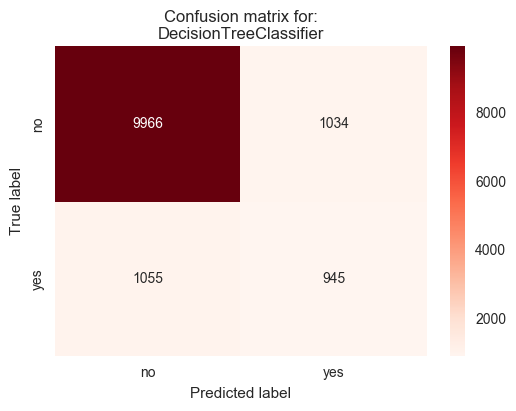

In [21]:
# Get confusion matrix (cm)
from tester_plus import test_classifier
cm = test_classifier(clf, my_dataset, features_list)

# Seaborn and matplotlib library
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# View confusion matrix with a heatmap
sns.heatmap(cm, annot=True, fmt = 'd', cmap='Reds', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(clf.__class__.__name__));

# Reference

1) [Udacity's Intro to Machine Learning](https://www.udacity.com/course/intro-to-machine-learning--ud120)     
2) [Enron wiki](https://en.wikipedia.org/wiki/Enron)     
3) [scikit-learn](http://scikit-learn.org/stable/)    
4) [Plotly Scatterplot](https://plot.ly/pandas/line-and-scatter/)     
5) [Bokeh Scatterplot](http://bokeh.pydata.org/en/latest/docs/user_guide/annotations.html#legends)     
6) [Bokeh Barchart](http://bokeh.pydata.org/en/latest/docs/user_guide/charts.html#bar-charts)      
7) [Optional code visibility](http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/)